# Power curve calculation


In order to properly calculate power from the cadence, an expression yielding the power in Watts must be given to Viscyc.

In this example, a table of power values from the manual of a crosstrainer is used to fit a function, which is then used in Viscyc.

An alternative would be, if the trainer has a display showing current power in Watts, to write down various rpm to Watt values empirically, and then proceed likewise.

In [1]:
import io
import numpy as np
import pandas as pd
from matplotlib import pyplot

# Luckily, in the manual of the Christopeit EL-5 Cross-trainer, 
# a table of the cadence / intensity level to Watt correspondence is given

# https://www.christopeit-sport.com/crosstrainer-ergometer-el-5/30-1721#downloads-accordion

# my AM-6 seems similar to this model, and the resulting formula matches the
# Power display on my trainer ...

# I'm setting my trainer to Level 15 and use the appropriate value in the code.

data_raw = """
Stufe 20 30 40 50 60 70 80 90 100 110 120
1 2 5 8 12 19 22 28 34 41 49 57
2 3 7 11 17 25 29 37 46 55 64 74
3 3 9 15 22 32 39 49 59 71 83 95
4 4 11 19 27 39 48 60 74 88 103 118
5 5 13 23 33 47 59 72 87 105 123 142
6 5 15 26 39 54 69 84 102 124 145 167
7 6 17 30 44 62 79 98 117 141 165 190
8 7 19 33 49 69 88 108 131 159 186 215
9 8 21 37 54 76 97 119 145 176 206 238
10 9 23 40 59 82 104 130 162 193 226 262
11 10 25 43 64 89 116 142 173 210 246 285
12 11 27 47 69 96 123 154 187 228 268 311
13 11 29 49 73 103 134 164 200 244 287 333
14 12 31 53 79 110 144 179 215 261 307 356
15 12 33 57 84 117 153 186 227 276 324 375
16 13 35 60 89 124 162 198 242 294 345 401
17 15 37 63 93 129 170 208 255 310 365 424
18 15 39 67 99 137 179 219 268 326 383 444
19 17 43 73 107 147 192 233 283 342 400 462
20 17 44 75 111 153 200 245 298 363 426 493
21 18 45 76 113 156 206 252 309 376 443 515
22 20 46 78 116 161 212 261 322 391 462 538
23 20 48 82 121 167 219 268 328 399 469 545
24 20 50 86 126 174 228 280 348 415 488 566
"""

data = pd.read_table(io.StringIO(data_raw), sep=' ')

# "translate"

data = data.rename(columns={'Stufe': 'Level'})


data

,Level,20,30,40,50,60,70,80,90,100,110,120
0,1,2,5,8,12,19,22,28,34,41,49,57
1,2,3,7,11,17,25,29,37,46,55,64,74
2,3,3,9,15,22,32,39,49,59,71,83,95
3,4,4,11,19,27,39,48,60,74,88,103,118
4,5,5,13,23,33,47,59,72,87,105,123,142
5,6,5,15,26,39,54,69,84,102,124,145,167
6,7,6,17,30,44,62,79,98,117,141,165,190
7,8,7,19,33,49,69,88,108,131,159,186,215
8,9,8,21,37,54,76,97,119,145,176,206,238
9,10,9,23,40,59,82,104,130,162,193,226,262


Lets first plot the curves to get an idea how they look

''

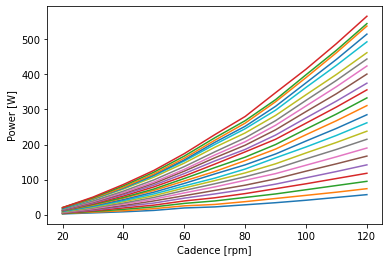

In [2]:
rpms = list(int(c) for c in data.columns if c != 'Level')
levels = data.Level

level_curves = {}

for level in levels:
    subset = data.query('Level == @level').copy()
    del subset['Level']
    subset = subset.transpose()
    x = [int(i) for i in subset.index]
    y = subset[subset.columns[0]].tolist()

    pyplot.plot(x, y, label=str(level))
    level_curves[level] = np.array((x, y))

pyplot.xlabel('Cadence [rpm]')
pyplot.ylabel('Power [W]')
''

Now we will think of a function which could model this relationship properly, and fit it using SciPy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

In [3]:
from inspect import signature, getsource

from scipy.optimize import curve_fit

def fit_function(x_level, factor, offset, x_corr, level_corr):
    x, level = x_level[:, 0], x_level[:, 1]
    return ((factor * (x+x_corr) ** 2) + offset) * (level + level_corr)

parameters = list(signature(fit_function).parameters)

level_curve_items = list(sorted(level_curves.items()))

l = len(level_curve_items[0][1][0])
total = np.zeros((len(level_curve_items) * l, 3))

for n, (level, (x, y)) in enumerate(level_curve_items):
    total[n*l:(n+1)*l, 0] = x
    total[n*l:(n+1)*l, 1] = y
    total[n*l:(n+1)*l, 2] = level

popt, pcov = curve_fit(fit_function, total[:, :2], total[:, 2])

popt = np.round(popt, 5)

print(f"cure_fit found {dict(zip(parameters[1:], popt))}")


errs = total[:, 2] - fit_function(
    total[:, :2], *popt
)

abs_err = np.abs(errs)

print()

print(f"Minimum error [Watt] {abs_err.min(): 8.3f}")
print(f"Maximum error [Watt] {abs_err.max(): 8.3f}")
print(f"   Mean error [Watt] {abs_err.mean(): 8.3f}")
    

cure_fit found {'factor': 3e-05, 'offset': 0.04069, 'x_corr': -113.37718, 'level_corr': 20.41185}

Minimum error [Watt]    0.012
Maximum error [Watt]   11.785
   Mean error [Watt]    2.152


The values can be substituted to the variables in the function, and the code can be used in a file passed to `--load` or as an expression.

The last block is more a bit of a joke, doing this manual step to produce a ready-to-use function; it's crude and will likely fail if you alter the function above.

In [4]:
# the last block is just a joke ;)
from itertools import chain

source = "\n".join(
    [line for line in getsource(fit_function).split('\n') if (parameters[0] not in line) or line.startswith('def')]
)

for variable, value in chain(zip(parameters[1:], popt), [
        ['x_level', 'rpm'],
        ['x', 'rpm'],
        ['+-', '-'],
    ]):
    source = source.replace(variable, str(value))


source = source.split("\n")
source[0] = 'def calculate_watt(rpm, level=15):'

source = "\n".join(source)

print(source)

def calculate_watt(rpm, level=15):
    return ((3e-05 * (rpm-113.37718) ** 2) + 0.04069) * (level + 20.41185)

